# Preprocessing the data

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
#import pysal.contrib.clusterpy as cp

from scipy import stats
from sklearn.mixture import GaussianMixture

/home/schanx/anaconda3/lib/python3.5/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
# Read GeoJSON file
abb = gpd.read_file('airbnb-listings.geojson')


abb.crs = {'init': u'epsg:27700'}
abb.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 85 columns):
review_scores_accuracy            1589 non-null float64
reviews_per_month                 1622 non-null float64
bathrooms                         2055 non-null float64
features                          2059 non-null object
listing_url                       2059 non-null object
transit                           1347 non-null object
room_type                         2059 non-null object
calendar_last_scraped             2059 non-null object
neighbourhood_cleansed            2059 non-null object
host_neighbourhood                1909 non-null object
street                            2059 non-null object
review_scores_communication       1589 non-null float64
longitude                         2059 non-null object
country_code                      2059 non-null object
review_scores_cleanliness         1589 non-null float64
neighborhood_overview             1305 non-null object


In [3]:
abb_original = gpd.read_file('airbnb-listings.geojson')
abb_original.crs = {'init': u'epsg:27700'}

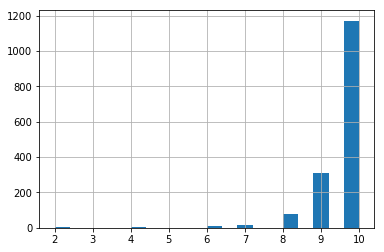

In [4]:
abb_original['review_scores_checkin'].hist(bins=20)

In [5]:
ratings = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
     'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
     'review_scores_value']

In [6]:
# feature selection
import json
with open('features/features.json') as f:
    features = json.load(f)
    #print(features['continuous_features'])
    
for i in features['continuous_features']:
    i=i.lower()
    #i=i.replace(" ","_")
    

contf=[(lambda x: x.lower().replace(" ","_"))(x) for x in features['continuous_features']]
contf.remove('host_total_listings_count')
contf.remove('host_acceptance_rate')

cat_features=['host_response_time','property_type','room_type','bed_type','host_verifications','amenities']
geo_features=["latitude","longitude","geometry"]
get_features=contf+cat_features+ratings+geo_features


# s = set()
# s=set(abb.columns.tolist())
# s=set(get_features).difference(s)
# get_features=[x for x in get_features if x not in list(s)]
# contf=[x for x in contf if x not in list(s)]

abb = abb[get_features]

In [7]:
len(get_features)

35

In [8]:
for i in ratings:
    abb[i]=abb[i].fillna(abb[i].median(skipna=True))

In [9]:
# 1st

# mapping of string based temporal data to numeric values
map=dict({'a':1,'day':1,'week':7,'month':30,'year':365,'yesterday':1,'today':0,'never':4000})

# calendar update
max_val=0
def get_days(data):
    if len(data)==1:
        return map.get(data[0])
    else:
        data[1]=data[1][:-1] if data[1][-1]=='s' else data[1]
        return map.get(data[0])*map.get(data[1]) if data[0] in map else int(data[0])*map.get(data[1]) # else int(data[0])*map.get(data[1]))
    
abb['calendar_updated']=abb['calendar_updated'].apply(lambda x: get_days(x.split()))

#abb.groupby(['Calendar Updated']).count()

In [10]:
# 2nd fill nans
for i in contf:
    abb[i]=abb[i].fillna(abb[i].median(skipna=True))

In [11]:
# 3rd normalize continuous data imputation
for imputed in abb[contf]:
    #imputed_boxcox_m, _ = stats.boxcox(abb[imputed])
    #imp_boxcox=pd.DataFrame(imputed_boxcox_m)
    #log transfrom
    abb[imputed]=np.log(abb[imputed]+1)
    # cube root transform
    #abb[imputed]=abb[imputed]**(1/3)
    print(abb[imputed])
    min_val = abb[imputed].min()
    max_val = abb[imputed].max()
    abb[imputed] = abb[imputed].apply(lambda x: (x - min_val) / (max_val - min_val))

0       6.803505
1       6.803505
2       6.803505
3       6.803505
4       6.803505
5       6.803505
6       6.803505
7       6.803505
8       6.803505
9       6.803505
10      6.803505
11      6.803505
12      6.803505
13      6.803505
14      6.803505
15      6.803505
16      6.803505
17      6.803505
18      6.803505
19      6.803505
20      6.803505
21      6.803505
22      6.803505
23      6.803505
24      6.803505
25      6.803505
26      6.803505
27      6.803505
28      6.803505
29      6.803505
          ...   
2029    6.803505
2030    6.803505
2031    6.803505
2032    7.090910
2033    7.090910
2034    6.803505
2035    6.803505
2036    6.803505
2037    6.803505
2038    6.803505
2039    6.803505
2040    6.803505
2041    6.803505
2042    6.803505
2043    6.803505
2044    6.803505
2045    6.803505
2046    6.803505
2047    6.803505
2048    6.803505
2049    6.803505
2050    6.803505
2051    6.803505
2052    6.803505
2053    6.803505
2054    6.803505
2055    6.803505
2056    6.8035

In [12]:
# 4th
# filled nans with a type

abb['host_verifications']=abb['host_verifications'].fillna('no_verification')
abb['amenities']=abb['amenities'].fillna('no_amenities')

# 5th 
import re

def clean_host_verifications(x):
    return ''.join(re.split(r'[\[\s\'\]\d]', x))
abb['host_verifications']=abb['host_verifications'].apply(lambda x: clean_host_verifications(x))

def clean_amenities(x):
    return ''.join(re.split(r'[\{\"\}:]', x))
abb['amenities']=abb['amenities'].apply(lambda x: clean_amenities(x))

abb['amenities']=abb['amenities'].apply(lambda x: x.replace("translation missing en.hosting_amenity_49",""))
abb['amenities']=abb['amenities'].apply(lambda x: x.replace("translation missing en.hosting_amenity_50",""))
abb['amenities']=abb['amenities'].apply(lambda x: x.replace("10.0",""))
abb['amenities']=abb['amenities'].apply(lambda x: x.rstrip(","))
abb['amenities']=abb['amenities'].apply(lambda x: x.lstrip(","))
abb['amenities']=abb['amenities'].apply(lambda x: re.sub(re.compile(r'(,){2,}'), ',', x))

abb['amenities']=abb['amenities'].apply(lambda x:'no_amenities' if x=='None' or x=='' else x)
abb['host_verifications']=abb['host_verifications'].apply(lambda x: 'no_verification' if x=='None' or x=='' else x)

In [13]:
#create new columns for verifications
# 5th
verifications_set=set()
verifications_set_amn=set()

def expand_as_cols(x):
    global verifications_set
    temp=x.split(",")
    verifications_set|=set(temp)
abb['host_verifications'].apply(lambda x: expand_as_cols(x))

def expand_as_cols(x):
    global verifications_set_amn
    temp=x.split(",")
    verifications_set_amn|=set(temp)
abb['amenities'].apply(lambda x: expand_as_cols(x))
print(verifications_set_amn)
print(verifications_set)

{'Hot Tub', 'Kitchen', 'Cat(s)', 'no_amenities', 'Smoking Allowed', 'Free Parking on Street', 'Pets Allowed', 'First Aid Kit', 'Dog(s)', 'Carbon Monoxide Detector', 'Hair Dryer', 'Air Conditioning', 'Hangers', 'Safety Card', 'Wireless Internet', 'Smoke Detector', 'Breakfast', 'Paid Parking Off Premises', 'Heating', 'Buzzer/Wireless Intercom', 'Washer', '24-Hour Check-in', 'Pets live on this property', 'Pool', 'Wheelchair Accessible', 'Essentials', 'Dryer', 'Cable TV', 'Gym', 'Washer / Dryer', 'Internet', 'Lock on Bedroom Door', 'Other pet(s)', 'Free Parking on Premises', 'Fire Extinguisher', 'TV', 'Suitable for Events', 'Doorman', 'Family/Kid Friendly', 'Shampoo', 'Laptop Friendly Workspace', 'Indoor Fireplace', 'Elevator in Building', 'Iron'}
{'phone', 'google', 'jumio', 'amex', 'weibo', 'kba', 'manual_offline', 'facebook', 'linkedin', 'no_verification', 'email', 'manual_online', 'reviews'}


In [14]:
len(cat_features)

6

In [15]:
#6 th
for i in verifications_set_amn:
    abb[i]=0
    
# encode 1 0 values
for i in abb.index.values.tolist():
    new_cols=abb['amenities'].loc[i].split(",")
    for j in new_cols:
        abb.at[i,j]=1
        
for i in verifications_set:
    abb[i]=0
    
# encode 1 0 values
for i in abb.index.values.tolist():
    new_cols=abb['host_verifications'].loc[i].split(",")
    for j in new_cols:
        abb.at[i,j]=1

abb.drop('host_verifications',1)
abb.drop('amenities',1)
abb.shape

(2059, 92)

In [16]:
abb.shape

(2059, 92)

In [17]:
# 7 th
import pandas as pd
cat_features.remove('host_verifications')
cat_features.remove('amenities')
temp=pd.get_dummies(abb[cat_features])
abb = gpd.GeoDataFrame(pd.concat([abb, temp], axis=1, join_axes=[abb.index]))

abb.drop(cat_features,axis=1,inplace=True)
abb.drop('host_verifications',axis=1,inplace=True)
abb.drop('amenities',axis=1,inplace=True)



In [18]:
len(abb.columns.tolist())

105

In [19]:
# END OF PREPROCESSING
abb.shape

(2059, 105)

# Experimented code

In [ ]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(contf):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, axes=ax, scheme='Quantiles', linewidth=0, colormap='Blues')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [ ]:
# clustering on continuous features

kmeans5 = cluster.KMeans(n_clusters=4)
k5cls = kmeans5.fit(abb[contf])
abb['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, axes=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic Kmeans classification for Boston')
# Display the map
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

diff_set=set(contf+ratings+geo_features)
l=set(abb.columns.tolist()).difference(diff_set)

principalComponents = pca.fit_transform(abb[list(l)])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

pcaCompDf = gpd.GeoDataFrame(principalDf.values)

In [ ]:
kmeans5 = cluster.KMeans(n_clusters=4)
k5cls = kmeans5.fit(pcaCompDf)
abb['pca_km_contpca_km_cont'] = k5cls.labels_

In [129]:
abb.shape

(2059, 105)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(pcaCompDf[0],pcaCompDf[1],pcaCompDf[2],
                     c=abb['pca_km_cont'],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_ylabel('PCA3')
plt.colorbar(scatter)

In [ ]:
# clustering on continuous features

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='pca_km_cont', categorical=True, legend=True, linewidth=0, axes=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic PCA + Kmeans classification for Boston')
# Display the map
plt.show()

In [ ]:
abb.co

In [ ]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, axes=ax, scheme='Quantiles', linewidth=0, colormap='Blues')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(['review_scores_location']):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    us_abb.plot(column=col, axes=ax, scheme='Quantiles', linewidth=0, colormap='Blues')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

kmeans5 = cluster.KMeans(n_clusters=4)

#k5cls = kmeans5.fit(abb[ratings])
k5cls = kmeans5.fit(us_abb[ratings])

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot unique values choropleth including a legend and with no boundary lines
us_abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, axes=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic classification for US')
# Display the map
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3)
f_list=[x for x in abb.columns.tolist() if x not in geo_features+ratings]
gmm.fit(abb[f_list])

In [ ]:
labels = gmm.predict(abb[f_list]) 
abb['labels']= labels

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='labels', categorical=True, legend=True, linewidth=0, axes=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic GMM Clustering for Boston')
# Display the map
plt.show()

# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(1, figsize=(5, 5))
abb.plot(column=col, axes=axs, scheme='Quantiles', linewidth=0, colormap='Blues')
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic GMM Clustering for Boston')
# Display the figure
plt.show()

In [ ]:
for i in range(0,3):
    print(abb_original.loc[abb['labels']==i]['price'].mean())
for i in range(0,3):
    print(abb.loc[abb['labels']==i].shape)

In [ ]:
########################################################
########################################################

######## END OF SCRATCH CODE ###########################


# Feature Selection

In [19]:
# Feature selection
f_list=[x for x in abb.columns.tolist() if x not in geo_features+ratings]

# Principal Component Analysis

In [20]:
###

#Principal Components Analysis

###
from sklearn.decomposition import PCA

## getting the categorical features
diff_set=set(contf+ratings+geo_features)
l=set(abb.columns.tolist()).difference(diff_set)

# ## remove host verifications and amenities
# l=l.difference(verifications_set_amn)
# l=l.difference(verifications_set)
#l=list()

l=list(l)

comp=5
pca = PCA(n_components=comp)
rem=["availability_30","availability_60","availability_90","availability_365"]
contf=[x for x in contf if x not in rem]
l=[x for x in l if x not in rem]
f_list=[x for x in f_list if x not in rem]


principalComponents = pca.fit_transform(abb[contf])

cols=[]
for i in range(0,comp):
    cols.append('principal comp'+str(i))

principalDf = pd.DataFrame(data = principalComponents
             , columns = cols)

pcaCompDf = gpd.GeoDataFrame(principalDf.values)

# BIC Score evaluation

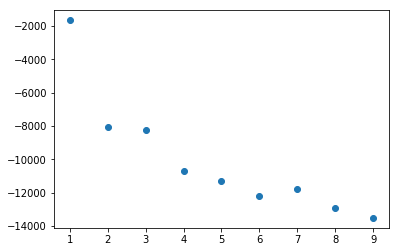

In [106]:
#####################

#### Find K #########

#####################

# Bayesian Information Criterion for GMM
# Lower the better

lst=[]
ilst=[]
for i in range(1,10):
    pca_gmm = GaussianMixture(n_components = i,covariance_type='full')
    pca_gmm.fit(pcaCompDf)
    bic_score=pca_gmm.bic(pcaCompDf)
    lst.append(bic_score)
    ilst.append(i)

#lst.index(min(lst))
plt.scatter(ilst,lst)
plt.show()

# PCA Energy 

In [107]:
pca.explained_variance_ratio_.cumsum()

array([0.31174448, 0.54184046, 0.66596261, 0.75127085, 0.80720925])

In [115]:
pcaCompDf = abb[contf]

# Clustering Algorithms

In [21]:
###############################

### Clustering methods ########

###############################

# # Kmeans
# from sklearn.cluster import KMeans
# pca_gmm = KMeans(n_clusters=5, random_state=0).fit(pcaCompDf)

# gmm
pca_gmm = GaussianMixture(n_components = 5,covariance_type='full')
pca_gmm.fit(pcaCompDf)

# # hierarchical clustering
# pcaCompDf=abb[l]
# from sklearn.cluster import AgglomerativeClustering
# pca_gmm=AgglomerativeClustering(n_clusters=5,linkage="single",affinity="euclidean")
# clustering = pca_gmm.fit(pcaCompDf)

# # spectral clustering
# from sklearn.cluster import SpectralClustering
# pca_gmm = SpectralClustering(n_clusters=5,assign_labels="discretize").fit(pcaCompDf)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

 # Silhouette Score evaluation

In [117]:
# Evaluation with Silhouette Score (inter cluster separation and within cluster similarity)
# Higher score the better

# Values between 0-1 signify mixtures
# Values < 0 means wrong cluster assignments

from sklearn import metrics

sil=[]
x=[]
bic=[]
# from sklearn.cluster import SpectralClustering
    
# for i in range(2,20):
#     # spectral clustering
#     pca_gmm = SpectralClustering(n_clusters=5,assign_labels="discretize").fit(pcaCompDf)
#     x.append(i)
#     sil.append(metrics.silhouette_score(pcaCompDf,pca_gmm.fit_predict(pcaCompDf), metric='euclidean'))
#     #bic.append(pca_gmm.bic(pcaCompDf))
    
# plt.scatter(x,sil)
# #plt.scatter(x,bic)
# plt.show()

metrics.silhouette_score(pcaCompDf,pca_gmm.fit_predict(pcaCompDf), metric='euclidean')

0.14998916966239612

# Label prediction and Plotting the PCs in 3d and 2d

In [22]:
labels = pca_gmm.fit_predict(pcaCompDf) 
pcaCompDf['labels']= labels

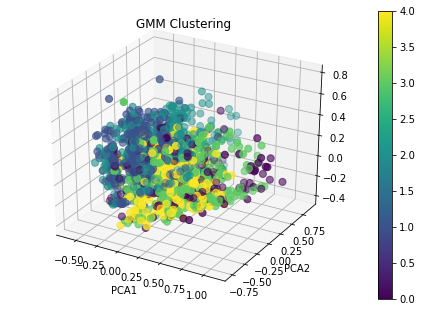

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax = plt.add_subplot(111)
scatter = ax.scatter(pcaCompDf[0],pcaCompDf[1],pcaCompDf[2],
                     c=pcaCompDf['labels'],s=50)
ax.set_title('GMM Clustering')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
#ax.set_zlabel('PCA3')
plt.colorbar(scatter)

In [24]:
###############################
##### cluster assignment#######
###############################
clusters=5

In [25]:
ratings_per_cluster=pd.DataFrame(columns=['cluster0','cluster1','cluster2','cluster3','cluster4'])

for i in range(0,clusters):
    for j in ratings:
        temp=abb_original.loc[pcaCompDf['labels']==i][j].mean()
        ratings_per_cluster.at[j,"cluster"+str(i)]=temp
ratings_per_cluster

,cluster0,cluster1,cluster2,cluster3,cluster4
review_scores_rating,92.3152,91.5609,92.4639,92.807,92.664
review_scores_accuracy,9.48913,9.35371,9.41346,9.52281,9.54878
review_scores_cleanliness,9.40217,9.26201,9.42067,9.43158,9.43902
review_scores_checkin,9.57065,9.5917,9.60817,9.71228,9.68293
review_scores_communication,9.65761,9.56987,9.52404,9.81053,9.71951
review_scores_location,9.47283,9.63158,9.67548,9.47018,9.5
review_scores_value,9.15217,9.06987,9.1851,9.21754,9.24797


In [26]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['price'].mean())

247.03365384615384
198.27080181543116
251.8556701030928
221.71559633027522
193.2967032967033


In [98]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['review_scores_communication'].mean())

9.326530612244898
9.627027027027028
9.802547770700636
9.091954022988507
9.702194357366771


In [99]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['review_scores_location'].mean())

9.581632653061224
9.533875338753388
9.614035087719298
9.574712643678161
9.545454545454545


In [100]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['review_scores_accuracy'].mean())

9.285714285714286
9.408108108108108
9.621019108280255
8.931034482758621
9.473354231974922


In [101]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['review_scores_checkin'].mean())

9.224489795918368
9.64054054054054
9.76751592356688
9.149425287356323
9.730407523510971


In [102]:
for i in range(0,clusters):
    print(abb_original.loc[pcaCompDf['labels']==i]['review_scores_rating'].mean())

91.08163265306122
91.78918918918919
93.89348171701113
88.47428571428571
92.115625


In [36]:
for i in range(0,clusters):
    print(pcaCompDf.loc[pcaCompDf['labels']==i].shape)

(279, 26)
(436, 26)
(399, 26)
(814, 26)
(131, 26)


/home/schanx/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


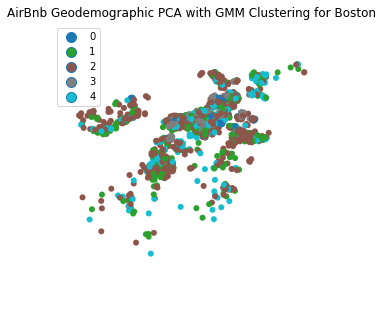

In [109]:
pcaCompDf['geometry']=abb['geometry']
pcaCompDf['latitude']=abb['latitude']
pcaCompDf['longitude']=abb['longitude']
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot unique values choropleth including a legend and with no boundary lines
pcaCompDf.plot(column='labels', categorical=True, legend=True, linewidth=0, axes=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic PCA with GMM Clustering for Boston')
# Display the map
plt.show()

In [37]:
pca.explained_variance_ratio_.cumsum()

array([0.14677773, 0.25073377, 0.30920453, 0.35440892, 0.39698282,
       0.43495212, 0.47016138, 0.50338781, 0.53011736, 0.55539376,
       0.57915566, 0.60240466, 0.62296452, 0.64193789, 0.66047742,
       0.67872694, 0.69657729, 0.71311681, 0.72877082, 0.74359632,
       0.75810433, 0.77089142, 0.78342663, 0.79554504, 0.80708914])

In [ ]:
pca.singular_values_

In [61]:
pca_features=pd.DataFrame(pca.components_,columns=abb[contf].columns,index=cols)

In [62]:
pca_features.apply(np.argmax ,axis=1)

principal comp0        extra_people
principal comp1            bedrooms
principal comp2    calendar_updated
principal comp3    security_deposit
principal comp4      minimum_nights
dtype: object

In [ ]:
pca_features.to_csv("pca_features_gmm.csv",sep=",")

In [93]:
pca_features.abs().T.nlargest(3,'principal comp4')

,principal comp0,principal comp1,principal comp2,principal comp3,principal comp4
security_deposit,0.015437,0.169503,0.045780,0.717117,0.649429
minimum_nights,0.060767,0.075207,0.069995,0.435805,0.533398
cleaning_fee,0.039598,0.212464,0.082898,0.428091,0.386847


In [ ]:
# declarations
from scipy.spatial import distance
listings_per_cluster=dict()
cluster_points_dists=dict()

In [ ]:
# Finding the feature importance
# Find the representative point in each cluster


for i in range(0,clusters):
    listings_per_cluster[i]=pcaCompDf.loc[pcaCompDf['labels']==i][[0,1,2,3]]
centroids = list(pca_gmm.means_[0])

# for i in range(0,len(listings_per_cluster)):
#    cluster_points_dists[i]=listings_per_cluster[i].apply(distance.euclidean(centroids, [0,1,2]))
#dist = numpy.linalg.norm(a-b)
#pcaCompDf.loc[pcaCompDf['labels']==0]
for i in range(0,5):
    for j in listings_per_cluster[i].index.values:
        if i in cluster_points_dists:
            cluster_points_dists[i].append(distance.euclidean(list(pca_gmm.means_[i]), list(listings_per_cluster[i].loc[j])))
        else:
            cluster_points_dists[i]=[distance.euclidean(list(pca_gmm.means_[i]), list(listings_per_cluster[i].loc[j]))]

In [ ]:
representative_points=dict()

for i in range(0,len(cluster_points_dists)):
    representative_points[i]=abb_original["review_scores_rating"].loc[np.argmax(cluster_points_dists[i])]
representative_points[0]

In [113]:
#for i in range(0,clusters):
#    listings_per_cluster[i]=pcaCompDf.loc[pcaCompDf['labels']==i][[0,1,2,3]]
cluster_based_points=dict()
#set_top_5_features_pca = ["availability_30","availability_60","availability_90","availability_365","calendar_updated","bathrooms","extra_people","bedrooms","guests_included","accommodates","beds"]
set_top_5_features_pca = ["cleaning_fee","minimum_nights","extra_people","security_deposit","calendar_updated","bathrooms","bedrooms","guests_included","accommodates","beds"]

#set_top_5_features_pca = ["Hair Dryer","Hangers", "Iron","host_response_time_within a few hours","Gym","Elevator in Building","availability_90","Fire Extinguisher","kba","jumio"]
#set_top_5_features_pca = ["Hair Dryer","Hangers", "Iron","host_response_time_within a few hours","Gym","Elevator in Building","Internet","Fire Extinguisher","kba","jumio"]

#set_top_5_features_pca =["extra_people","bedrooms","accommodates","security_deposit","cleaning_fee","minimum_nights"]
#set_top_5_features_pca = ["Hair Dryer","Hangers", "Iron","host_response_time_within a few hours","Gym","Elevator in Building","Fire Extinguisher","kba","jumio"]

for i in range(0,clusters):
    cluster_based_points[i]=abb.loc[pcaCompDf['labels']==i][set_top_5_features_pca]

cluster_based_avg_per_f=dict()

for i in range(0,clusters):
    for j in set_top_5_features_pca:
        if i in cluster_based_avg_per_f:
            cluster_based_avg_per_f[i].append(cluster_based_points[i][j].mean())
        else:
            cluster_based_avg_per_f[i]=[cluster_based_points[i][j].mean()]

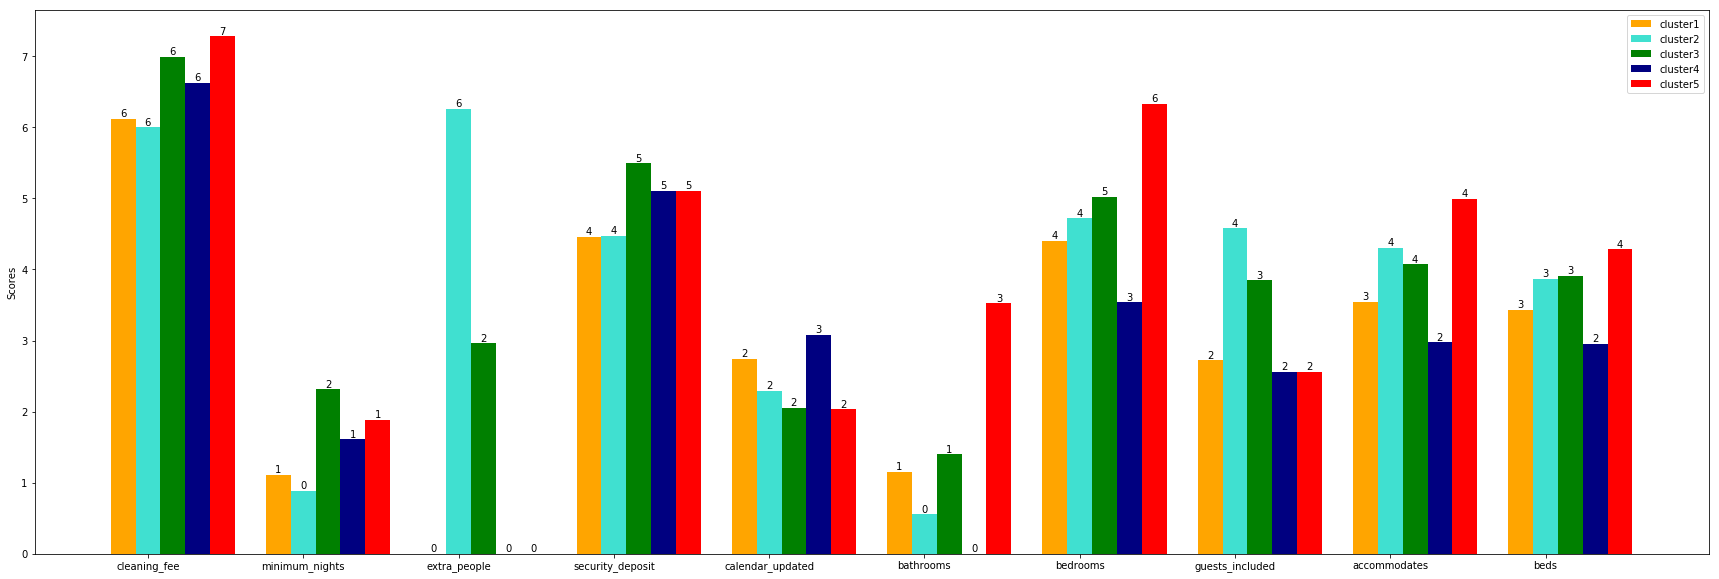

In [114]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(len(set_top_5_features_pca))  # the x locations for the groups
width = 0.16       # the width of the bars

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)


i=10
yvals = [i*x for x in cluster_based_avg_per_f[0]]
rects1 = ax.bar(ind, yvals, width, color='orange')
zvals = [i*x for x in cluster_based_avg_per_f[1]]
rects2 = ax.bar(ind+width, zvals, width, color='turquoise')
kvals = [i*x for x in cluster_based_avg_per_f[2]]
rects3 = ax.bar(ind+width*2, kvals, width, color='green')
lvals = [i*x for x in cluster_based_avg_per_f[3]]
rects4 = ax.bar(ind+width*3, lvals, width, color='navy')
mvals = [i*x for x in cluster_based_avg_per_f[4]]
rects5 = ax.bar(ind+width*4, mvals, width, color='red')


ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels((set_top_5_features_pca))
ax.legend( (rects1[0], rects2[0], rects3[0],rects4[0],rects5[0]), ('cluster1', 'cluster2', 'cluster3','cluster4','cluster5') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

#abb.columns.tolist()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [1, 2, 2]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)


modelG=pd.DataFrame(abb[contf])
# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(modelG)
        bic.append(gmm.bic(modelG))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(modelG)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(modelG[Y_ == i, 0], modelG[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [ ]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, axes=ax, scheme='Quantiles', linewidth=0, colormap='Blues')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()